Loading and preparing data...
Total samples after balancing: 19302
Fraud cases: 9651
Non-fraud cases: 9651

Performing feature engineering...

Splitting data into training and testing sets...

=== Dataset Dimensions and Features Analysis ===

1. Basic Dimensions:
Total dataset size: 19302
Training set: 15441 samples (80.0%)
Testing set: 3861 samples (20.0%)

2. Class Distribution:
Training set:
is_fraud
1    50.0%
0    50.0%
Name: proportion, dtype: object

Testing set:
is_fraud
0    50.0%
1    50.0%
Name: proportion, dtype: object

3. Feature Information:
                   Feature     Type  Non-Null Count  Null Count  Unique Values
cc_num              cc_num    int64           15441           0            999
category          category    int64           15441           0             14
amt                    amt  float64           15441           0          11800
zip                    zip  float64           15441           0            985
lat                    lat  float64       

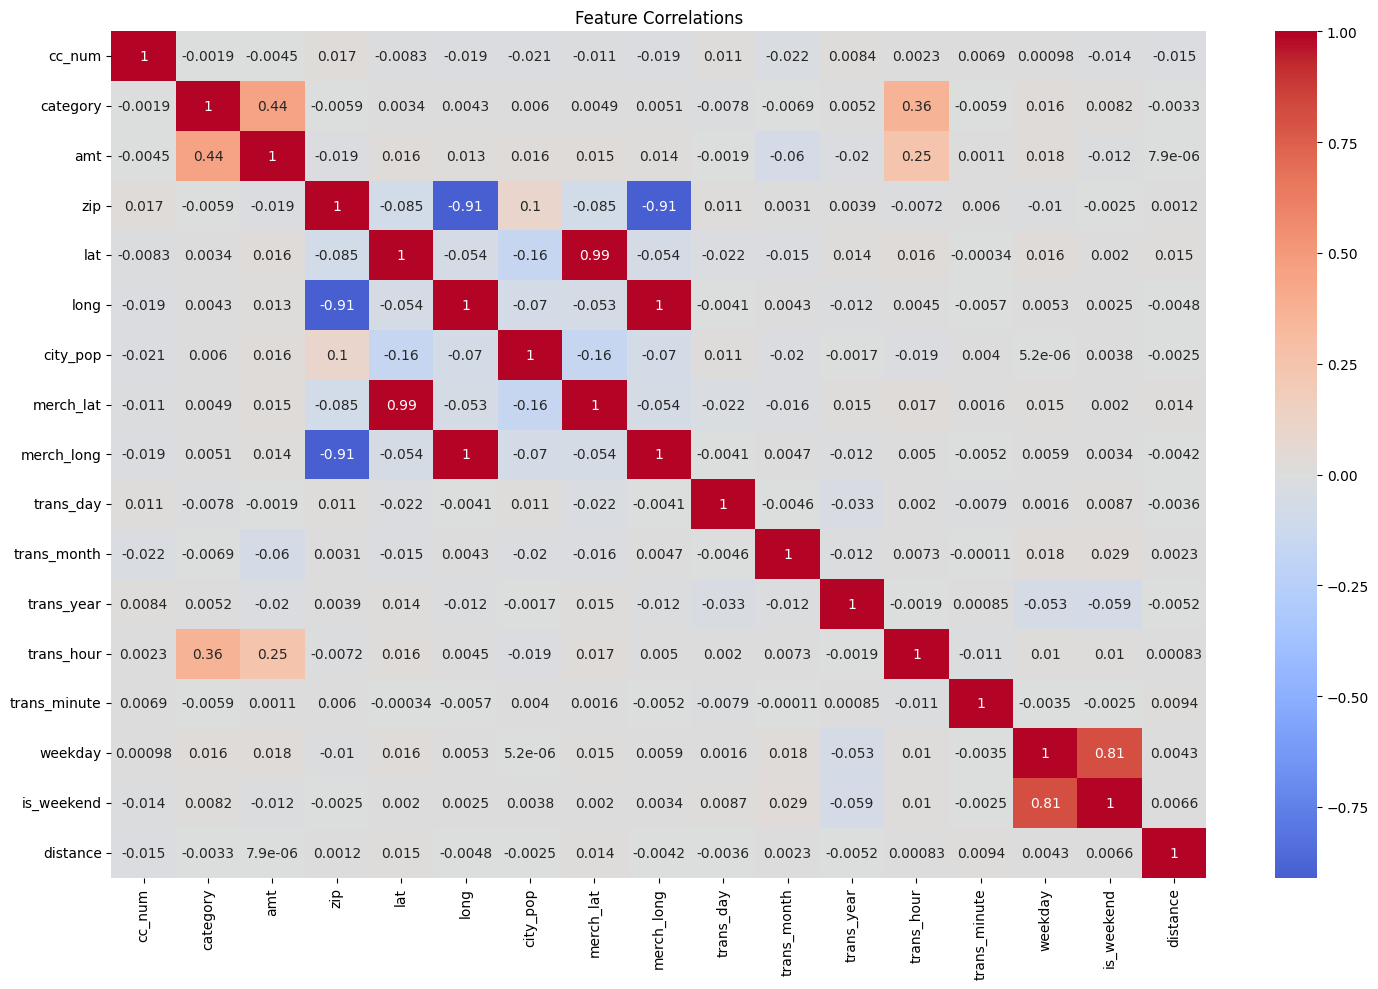

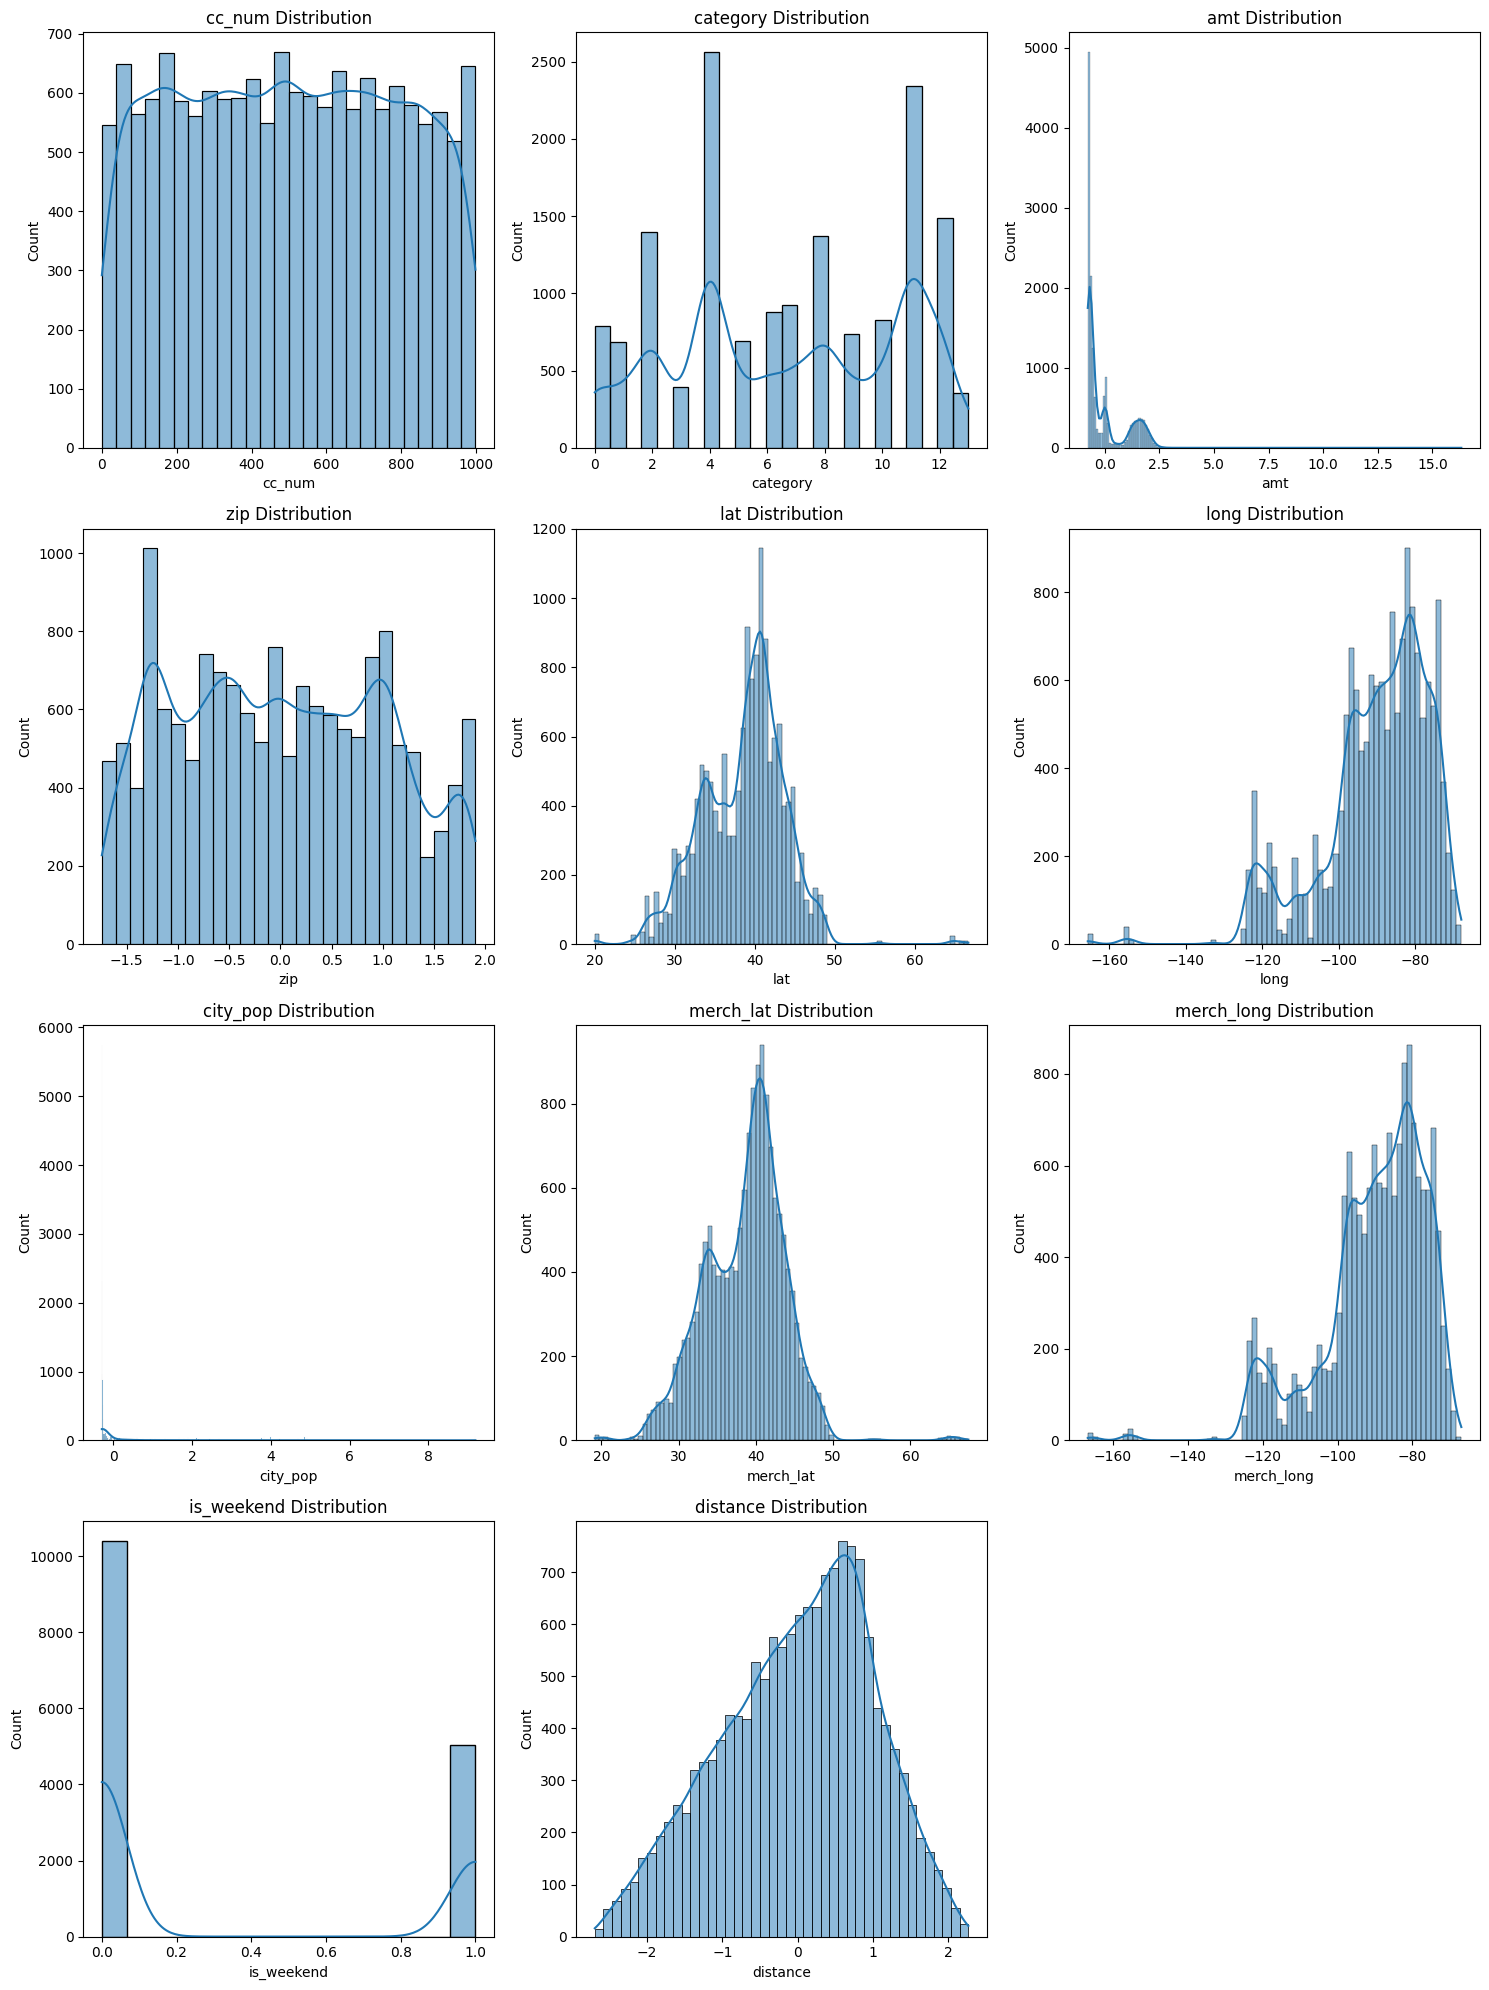


Training and evaluating models:
----------------------------------------------------------------------------------------------------

Training Random Forest...

Random Forest Results:
--------------------------------------------------
Training Accuracy: 0.9730
Testing Accuracy: 0.9542
Accuracy Difference (Overfitting Measure): 0.0188
Precision: 0.9587
Recall: 0.9492
F1 Score: 0.9539
Average Precision: 0.9915

Confusion Matrix:
[[1852   79]
 [  98 1832]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1931
           1       0.96      0.95      0.95      1930

    accuracy                           0.95      3861
   macro avg       0.95      0.95      0.95      3861
weighted avg       0.95      0.95      0.95      3861

--------------------------------------------------

Training Logistic Regression...

Logistic Regression Results:
--------------------------------------------------
Training Accuracy: 0.8529

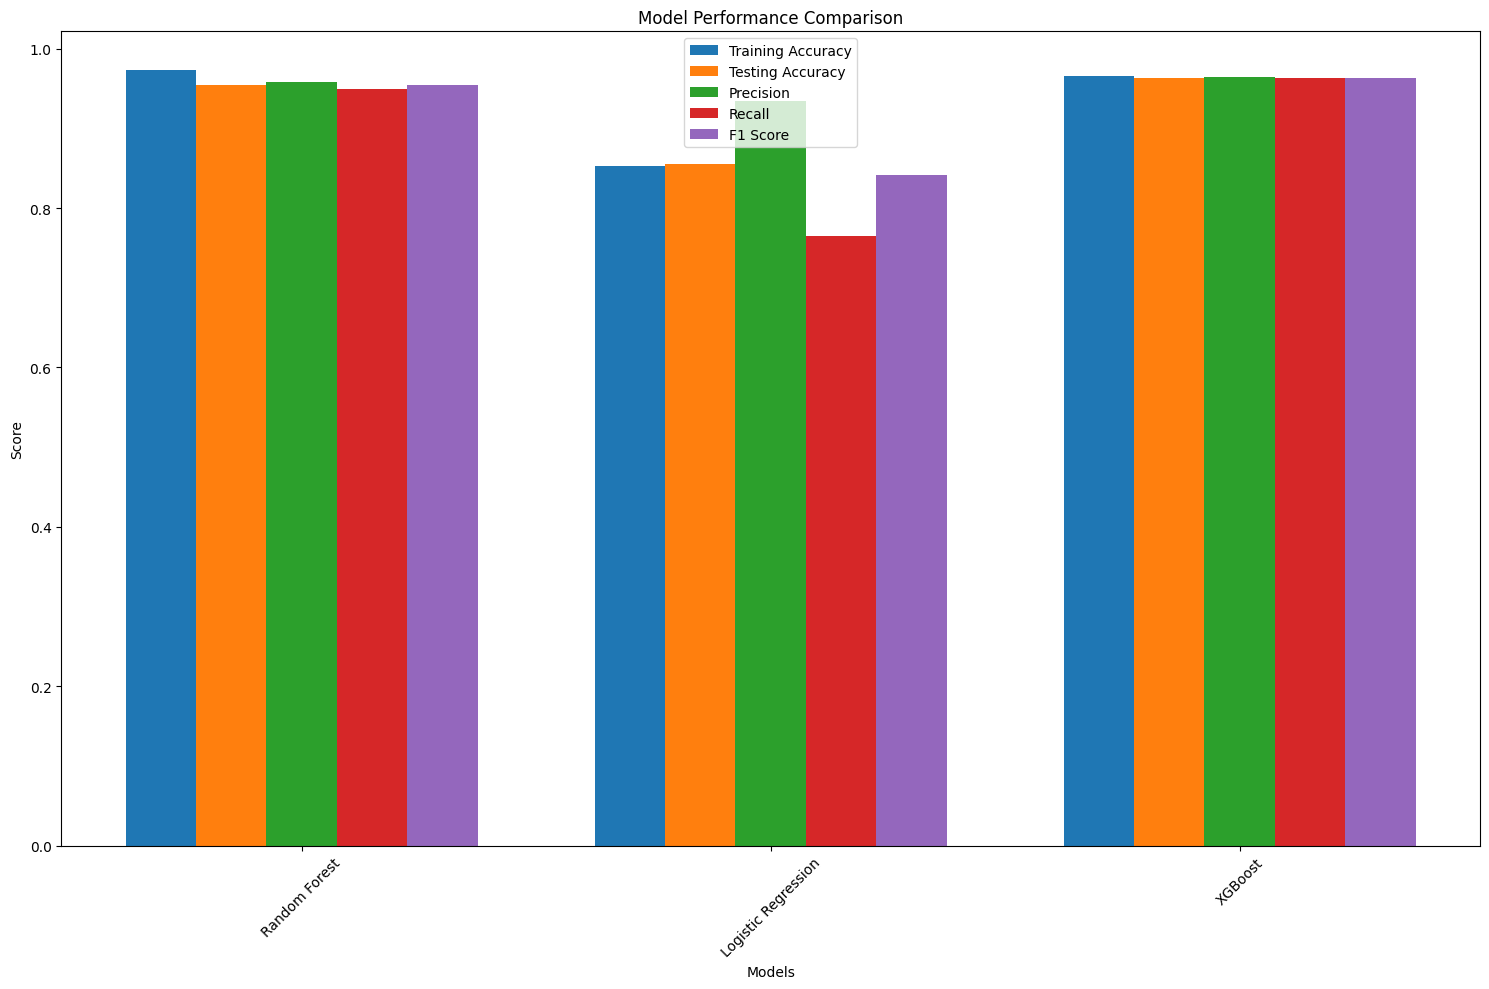

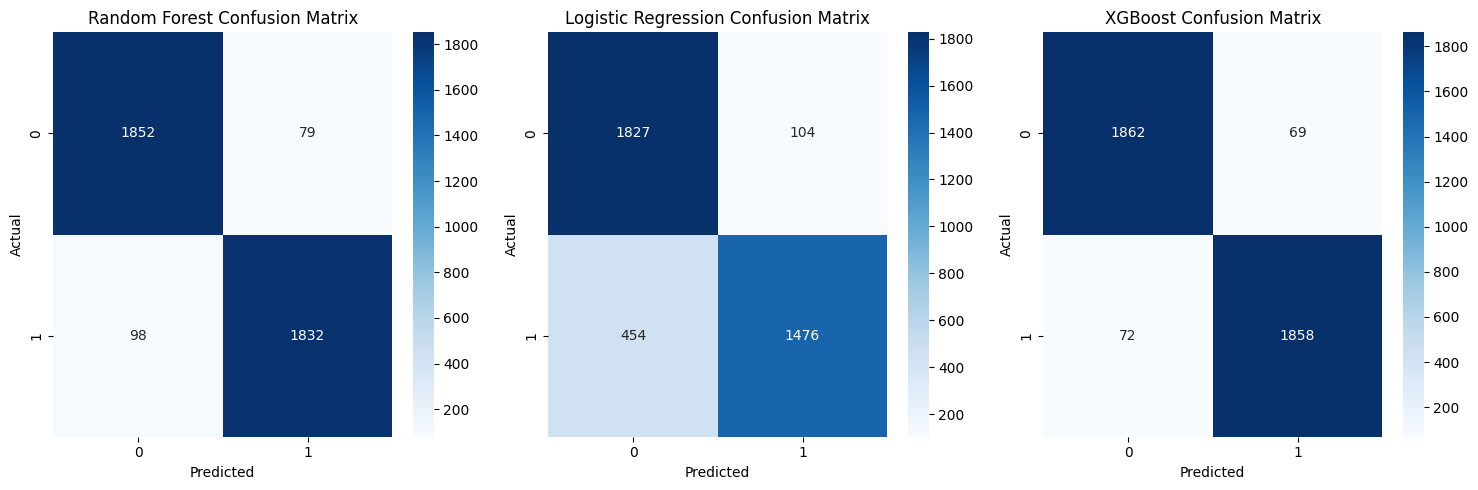


Best model saved as fraud_detection_model.pkl


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                           roc_curve, auc, precision_recall_curve, average_precision_score,
                           precision_score, recall_score, f1_score)
import pickle
import warnings
warnings.filterwarnings('ignore')

class FraudDetectionSystem:
    def __init__(self):
        self.scaler = StandardScaler()
        self.encoder = LabelEncoder()
        self.best_model = None

    def load_and_prepare_data(self, train_path, test_path):
        # Load data
        print("Loading and preparing data...")
        data_train = pd.read_csv('/content/fraudTrain.csv')
        data_test = pd.read_csv('/content/fraudTest.csv')
        full_data = pd.concat([data_train, data_test])

        # Basic preprocessing
        full_data = full_data.dropna()

        # Balance the dataset
        fraud = full_data[full_data["is_fraud"]==1]
        not_fraud = full_data[full_data["is_fraud"]==0].sample(fraud.shape[0])
        data = pd.concat([fraud, not_fraud])

        print(f"Total samples after balancing: {len(data)}")
        print(f"Fraud cases: {len(fraud)}")
        print(f"Non-fraud cases: {len(not_fraud)}")

        return self.feature_engineering(data)

    def feature_engineering(self, data):
        print("\nPerforming feature engineering...")
        # Drop unused columns
        unused_cols = ['Unnamed: 0', 'first', 'last', 'unix_time', 'street',
                      'gender', 'job', 'dob', 'city', 'state', 'trans_num', 'merchant']
        data.drop(columns=unused_cols, inplace=True)

        # Convert transaction datetime and extract features
        data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
        data['trans_day'] = data['trans_date_trans_time'].dt.day
        data['trans_month'] = data['trans_date_trans_time'].dt.month
        data['trans_year'] = data['trans_date_trans_time'].dt.year
        data['trans_hour'] = data['trans_date_trans_time'].dt.hour
        data['trans_minute'] = data['trans_date_trans_time'].dt.minute
        data['weekday'] = data['trans_date_trans_time'].dt.weekday
        data['is_weekend'] = data['weekday'].isin([5, 6]).astype(int)
        data.drop(columns=['trans_date_trans_time'], inplace=True)

        # Calculate distance between merchant and card holder
        data['distance'] = np.sqrt(
            (data['lat'] - data['merch_lat'])**2 +
            (data['long'] - data['merch_long'])**2
        )

        # Encode categorical variables
        data['category'] = self.encoder.fit_transform(data['category'])
        data['cc_num'] = self.encoder.fit_transform(data['cc_num'])

        # Scale numerical features
        numerical_features = ['amt', 'zip', 'city_pop', 'distance']
        data[numerical_features] = self.scaler.fit_transform(data[numerical_features])

        return data

    def analyze_feature_correlations(self, X_train):
        plt.figure(figsize=(15, 10))
        sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlations')
        plt.tight_layout()
        plt.show()

    def analyze_feature_distributions(self, X_train):
        numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns
        n_features = len(numerical_features)
        n_cols = 3
        n_rows = (n_features + n_cols - 1) // n_cols

        plt.figure(figsize=(15, 5*n_rows))
        for i, feature in enumerate(numerical_features, 1):
            plt.subplot(n_rows, n_cols, i)
            sns.histplot(X_train[feature], kde=True)
            plt.title(f'{feature} Distribution')
        plt.tight_layout()
        plt.show()

    def evaluate_model(self, model, X_train, X_test, y_train, y_test, name):
        # Training predictions
        y_train_pred = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)

        # Testing predictions
        y_test_pred = model.predict(X_test)
        y_test_prob = model.predict_proba(X_test)[:, 1]
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # Calculate comprehensive metrics
        metrics = {
            'Model Name': name,
            'Training Accuracy': train_accuracy,
            'Testing Accuracy': test_accuracy,
            'Accuracy Difference': train_accuracy - test_accuracy,
            'Precision': precision_score(y_test, y_test_pred),
            'Recall': recall_score(y_test, y_test_pred),
            'F1 Score': f1_score(y_test, y_test_pred),
            'ROC AUC': roc_curve(y_test, y_test_prob),
            'Average Precision': average_precision_score(y_test, y_test_prob),
            'Confusion Matrix': confusion_matrix(y_test, y_test_pred),
            'Classification Report': classification_report(y_test, y_test_pred)
        }

        return metrics

    def train_and_compare_models(self, data):
        print("\nSplitting data into training and testing sets...")
        X = data.drop('is_fraud', axis=1)
        y = data['is_fraud']
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Comprehensive dataset analysis
        print("\n=== Dataset Dimensions and Features Analysis ===")
        print("\n1. Basic Dimensions:")
        print(f"Total dataset size: {len(data)}")
        print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(data)*100:.1f}%)")
        print(f"Testing set: {X_test.shape[0]} samples ({X_test.shape[0]/len(data)*100:.1f}%)")

        print("\n2. Class Distribution:")
        print("Training set:")
        print(pd.Series(y_train).value_counts(normalize=True).apply(lambda x: f"{x*100:.1f}%"))
        print("\nTesting set:")
        print(pd.Series(y_test).value_counts(normalize=True).apply(lambda x: f"{x*100:.1f}%"))

        print("\n3. Feature Information:")
        feature_info = pd.DataFrame({
            'Feature': X_train.columns,
            'Type': X_train.dtypes,
            'Non-Null Count': X_train.count(),
            'Null Count': X_train.isnull().sum(),
            'Unique Values': [X_train[col].nunique() for col in X_train.columns]
        })
        print(feature_info)

        print("\n4. Numerical Features Statistics:")
        numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns
        print(X_train[numerical_features].describe())

        # Analyze feature correlations and distributions
        self.analyze_feature_correlations(X_train)
        self.analyze_feature_distributions(X_train)

        # Initialize models
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10,
                                                  random_state=42, n_jobs=-1),
            'Logistic Regression': LogisticRegression(C=1.0, max_iter=1000,
                                                    random_state=42),
            'XGBoost': xgb.XGBClassifier(max_depth=3, learning_rate=0.1,
                                       n_estimators=100, random_state=42, n_jobs=-1)
        }

        # Train and evaluate models
        results = {}
        print("\nTraining and evaluating models:")
        print("-" * 100)

        for name, model in models.items():
            print(f"\nTraining {name}...")
            model.fit(X_train, y_train)
            metrics = self.evaluate_model(model, X_train, X_test, y_train, y_test, name)
            results[name] = metrics

            print(f"\n{name} Results:")
            print("-" * 50)
            print(f"Training Accuracy: {metrics['Training Accuracy']:.4f}")
            print(f"Testing Accuracy: {metrics['Testing Accuracy']:.4f}")
            print(f"Accuracy Difference (Overfitting Measure): {metrics['Accuracy Difference']:.4f}")
            print(f"Precision: {metrics['Precision']:.4f}")
            print(f"Recall: {metrics['Recall']:.4f}")
            print(f"F1 Score: {metrics['F1 Score']:.4f}")
            print(f"Average Precision: {metrics['Average Precision']:.4f}")
            print("\nConfusion Matrix:")
            print(metrics['Confusion Matrix'])
            print("\nClassification Report:")
            print(metrics['Classification Report'])
            print("-" * 50)

        # Find best model
        best_model_name = max(results.items(),
                            key=lambda x: x[1]['Testing Accuracy'])[0]
        self.best_model = models[best_model_name]

        # Plot feature importance if using Random Forest
        if isinstance(self.best_model, RandomForestClassifier):
            plt.figure(figsize=(12, 6))
            importances = pd.DataFrame({
                'feature': X_train.columns,
                'importance': self.best_model.feature_importances_
            }).sort_values('importance', ascending=False)

            sns.barplot(x='importance', y='feature', data=importances)
            plt.title('Feature Importance')
            plt.xlabel('Importance Score')
            plt.tight_layout()
            plt.show()

        print(f"\nBest performing model: {best_model_name}")

        return results, X_test, y_test

    def visualize_results(self, results, X_test, y_test):
        # Plotting metrics comparison
        plt.figure(figsize=(15, 10))

        metrics_to_plot = ['Training Accuracy', 'Testing Accuracy',
                          'Precision', 'Recall', 'F1 Score']

        x = np.arange(len(results))
        width = 0.15

        for i, metric in enumerate(metrics_to_plot):
            values = [result[metric] for result in results.values()]
            plt.bar(x + i*width, values, width, label=metric)

        plt.xlabel('Models')
        plt.ylabel('Score')
        plt.title('Model Performance Comparison')
        plt.xticks(x + width*2, results.keys(), rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Plot confusion matrices
        plt.figure(figsize=(15, 5))
        for i, (name, result) in enumerate(results.items(), 1):
            plt.subplot(1, len(results), i)
            sns.heatmap(result['Confusion Matrix'], annot=True, fmt='d',
                       cmap='Blues')
            plt.title(f'{name} Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

    def save_model(self, filename='fraud_detection_model.pkl'):
        if self.best_model is not None:
            with open(filename, 'wb') as f:
                pickle.dump({
                    'model': self.best_model,
                    'scaler': self.scaler,
                    'encoder': self.encoder
                }, f)
            print(f"\nBest model saved as {filename}")
        else:
            print("\nNo model to save. Please train the model first.")

# Run the system
if __name__ == "__main__":
    # Initialize the system
    fds = FraudDetectionSystem()

    # Load and prepare data
    data = fds.load_and_prepare_data('fraudTrain.csv', 'fraudTest.csv')

    # Train and compare models
    results, X_test, y_test = fds.train_and_compare_models(data)

    # Visualize results
    fds.visualize_results(results, X_test, y_test)

    # Save the best model
    fds.save_model()